In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Archimedes procedure for porous material density determination

Experimental procedure is as follow, for further detail refer to standard ASTM D7263. 

1. Measure temperature of liquid to determine its ($\rho_{\text{water}}$). Find object theoretical full density ( $\rho_{\text{solid}}$ ) and wax density ($\rho_{wax}$) from datasheet
2. Measure mass of sample(s) ($M_t$)
3. Apply two coats of wax to the sample(s)
4. Measure mass of Coated sample(s) ($M_c$)
5. Measure mass of Coated Sample(s) submerged ($M_{sub}$)


\begin{equation}
    \text{density}, \rho_b = \frac{M_t}{\frac{(M_c - M_{sub})}{\rho_{water}} - \frac{(M_c - M_t)}{\rho_{wax}}}
\end{equation}


\begin{equation}
    \text{true density}, \pi_d = \frac{ \rho_b}{\rho_{\text{solid}}} * 100
\end{equation}

Parts using two powder type are made. Parts labeled bimodal should have a higher density then parts labelled unimodal.

## Display first few row of excel sheet

In [2]:
data = pd.read_excel('./data/green_sample_benchmark.xlsx', sheet_name = 'wax', index_col= [0,1])
oil_density = pd.read_excel('./data/green_sample_benchmark.xlsx', sheet_name = 'wax_param', index_col= 0)

In [3]:
data.head()

powder type  dry weight  coated weight  wet coated  exp  operator
batch ID                                                                  
2     3      Bimodal     16.1233        16.7750     12.6154    1         1
      4      Bimodal     15.6583        16.3665     12.1851    1         1
1     1     Unimodal     14.9923        16.7300     11.3864    1         1
      5     Unimodal     15.5877        16.7838     12.0242    1         1
4     2     Unimodal     14.8018        15.4759     11.1873    2         1

## Display first few row of excel sheet

In [4]:
oil_density.head()

,wax density,water density
exp,,
1,0.961,0.997300
2,0.930,0.998020
3,0.930,0.998203


## Carrier fluid density

Density of the carrier fluid ($\rho_{\text{water}}$) is necessary for density calculation. Since the density of the fluid fluctuate depending on temperature and temperature varies from experiment to experiment, it is recorded for each experiment. For experiment 2 it was recorded at the beginning and at the end.

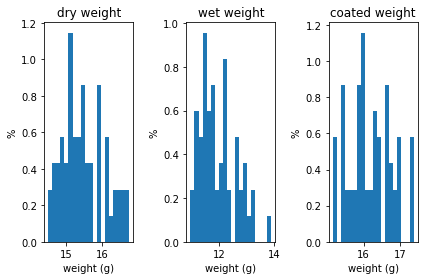

In [5]:
def plot_hist(data, b):
    fig, axes = plt.subplots(1,3)
    axes[0].hist(data['dry weight'], bins = b, density = True)
    axes[0].set_title('dry weight')
    axes[0].set_xlabel('weight (g)')
    axes[0].set_ylabel('%')

    axes[1].hist(data['wet coated'], bins = b, density = True)
    axes[1].set_title('wet weight')
    axes[1].set_xlabel('weight (g)')
    axes[1].set_ylabel('%')

    axes[2].hist(data['coated weight'], bins = b, density = True)
    axes[2].set_title('coated weight')
    axes[2].set_xlabel('weight (g)')
    axes[2].set_ylabel('%')

    plt.tight_layout()
    plt.show()

plot_hist(data, 20)

In [6]:
data = data.dropna()

## Compute density
Each sample was measured 3 times at each stage. Since we are only interested in the uncertainty in the true density ($\pi_d$), a cartesian product of each measured weights (dry, wet and coated) and liquid density is done for each sample in order to compute true density.

In [7]:
from itertools import product
from sklearn import preprocessing

density_df = pd.DataFrame(columns = ['batch', 'id', 'density', 'operator', 'powder'])

# density of stainless steel 316L (g/cc) taken from data sheet
den_ss316 = 8.0

unique_id = 0

# iterate over each sample to do cartesian product
for idx in data.index.unique():
    sample = data.loc[idx]

    op = int(np.unique(sample['operator']).squeeze())
    powder = str(np.unique(sample['powder type']).squeeze())
    batch = idx[0]
    
    d_weight = sample['dry weight'].to_numpy()
    wc_weight = sample['wet coated'].to_numpy()
    c_weight = sample['coated weight'].to_numpy()

    exp_num = sample['exp']
    
    # density of liquid and wax taken from datasheet
    water_den = np.unique(oil_density.loc[exp_num]['water density'].to_numpy())
    wax_den = np.unique(oil_density.loc[exp_num]['wax density'].to_numpy())
    
    # cartesian product
    prod = product(d_weight, wc_weight, c_weight, water_den, wax_den)

    for d_w, wc_w, c_w, water_d, wax_d in prod:
        #compute true density refer to equation on top
        den = (d_w/((c_w - wc_w)/water_d - (c_w - d_w)/wax_d))/den_ss316*100
        new_entry = {
            'batch' : batch,
            'id' : unique_id,
            'density' : float(den.squeeze()),
            'operator' : op,
            'powder' : powder
        }

        density_df = density_df.append(new_entry, ignore_index = True)
    
    unique_id += 1

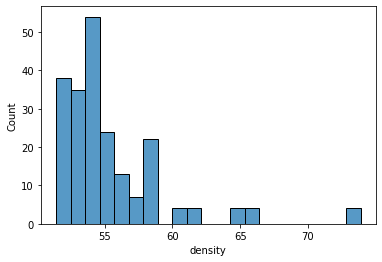

In [8]:
ax = sns.histplot(density_df['density'])

In [9]:
density_df.to_csv('./data/density_wax.csv', index=False)

In [10]:
basic_model = pm.Model()

n_part = unique_id

powder_mean = density_df.groupby('powder').mean()['density']

part_id = density_df['id'].to_numpy().astype(np.int32)
obs_den = density_df['density'].to_numpy().astype(np.int32)

# Relabel data to integers
powder_enc = preprocessing.LabelEncoder()
powder_enc.fit(['Unimodal','Bimodal'])
powder_data = powder_enc.transform(density_df['powder'])

#compute starting point for mean inference
test_val_mu = [powder_mean[c] for c in powder_enc.classes_]

A = 10000
with basic_model:
    
    # setup independent mu_i
    mu_p = pm.Uniform('muP', 20.0, 60.0, shape = 2, testval = test_val_mu)
    mu_real = pm.math.switch(powder_data, mu_p[1], mu_p[0])
    
    # setup prior for part variance and error variance
    sig_repeat = pm.HalfCauchy('sig_repeat', 25)
    sig_part = pm.HalfCauchy('sig_part', 25)
    
    # each part will vary independently (nesting relationship)
    P_t = pm.Normal('P_t', mu = 0, sigma = 1, shape = n_part)
    
    # setup mu
    mu = pm.Deterministic('mu', mu_real + P_t[part_id]*sig_part)
    
    # add error and data to model
    density = pm.Normal('density', mu = mu, sigma = sig_repeat, observed = obs_den)


In [11]:
with basic_model:
    trace = pm.sample(A, chains = 4, tune = 2000, target_accept=0.9)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P_t, sig_part, sig_repeat, muP]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 48000/48000 [00:37<00:00, 1276.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:35<00:00, 1141.96it/s]


Convert trace to arviz data format for diagnostic

In [12]:
trace_data_az = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=basic_model
)

In [13]:
trace_data_az.to_netcdf('./data/wax_trace.nc')

'./data/wax_trace.nc'

## Trace plot
The sampler is exploring the probability space by sampling different values of the model input parameters ($\mu_i, \sigma_{\text{part}}, \sigma_{\text{gage}}$). The left graph shows the probability density of the sampled values. The right graph shows the sampled with respect to sample number. The left graph is computed by summing up the right graph. When the left graph looks skewed towards zero or the right graph does not resemble a thick caterpillar, this indicates a biased sampling and a lack of convergence. 

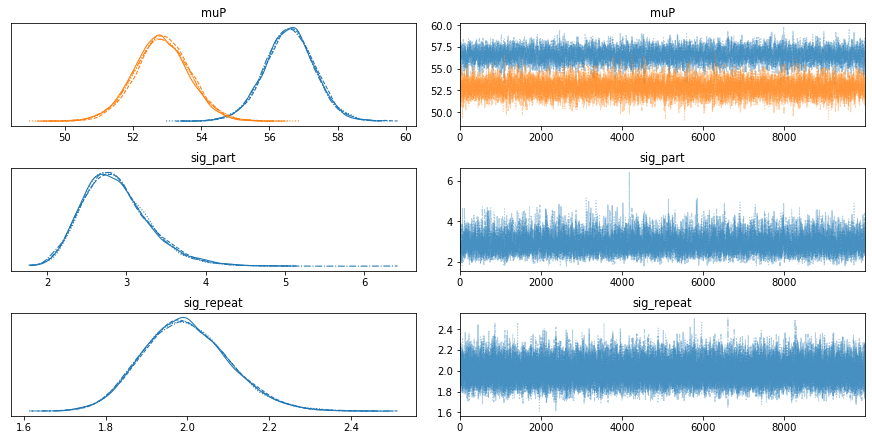

In [14]:
pm.traceplot(trace, var_names=['muP','sig_part','sig_repeat'])
plt.show()

## Predictive check plot

Predictive posterior plot overlays data generated by the model's posterior over the real data. This is useful to check the fitness of the model. 

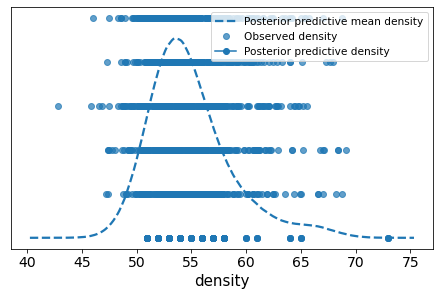

In [15]:
az.plot_ppc(trace_data_az, data_pairs={"density":"density"}, kind = 'scatter')
plt.show()

## Forest plot

Forest plot on estimated real mean $\mu_{i}$ to check if the values make sense

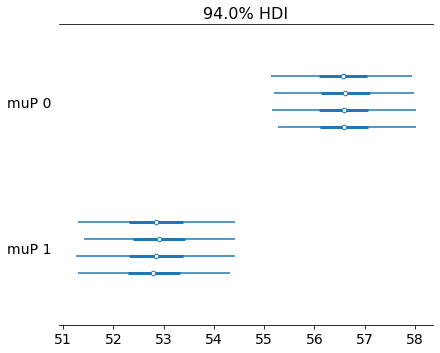

In [16]:
pm.plots.forestplot(trace, var_names=['muP'])
plt.show()

## Compute split $\hat{R}$ 

In the Markov-Chain Monte Carlo (MCMC) sampler, the sampling is done simultaneously in multiple processes (chain). The rank normalized $\hat{R}$ checks for convergence by comparing the variance between chain with the variance within chain. If convergence has been achieved then the variance should be the same ($\hat{R}=1$) (Vehtari et al). [Vehtari et al.](https://arxiv.org/pdf/1903.08008v1.pdf "vehtari") recommends a $\hat{R} < 1.01$.


In [17]:
az.rhat(trace_data_az)

<xarray.Dataset>
Dimensions:     (P_t_dim_0: 31, muP_dim_0: 2, mu_dim_0: 213)
Coordinates:
  * P_t_dim_0   (P_t_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30
  * muP_dim_0   (muP_dim_0) int32 0 1
  * mu_dim_0    (mu_dim_0) int32 0 1 2 3 4 5 6 7 ... 206 207 208 209 210 211 212
Data variables:
    P_t         (P_t_dim_0) float64 1.0 1.0 1.0 1.0 ... 1.001 1.002 1.001 1.001
    muP         (muP_dim_0) float64 1.001 1.002
    sig_repeat  float64 1.0
    sig_part    float64 1.0
    mu          (mu_dim_0) float64 1.0 1.0 1.0 1.0 ... 0.9999 0.9999 0.9999

## Calculate highest density interval (HDI)

Taken from [arviz doc](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html#arviz.hdi "arviz") : The HDI is the minimum width Bayesian credible interval (BCI).

In [18]:
hdi_data = az.hdi(trace_data_az)
hdi_data.to_netcdf('./data/wax_inference.nc')
hdi_data

<xarray.Dataset>
Dimensions:     (P_t_dim_0: 31, hdi: 2, muP_dim_0: 2, mu_dim_0: 213)
Coordinates:
  * P_t_dim_0   (P_t_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30
  * muP_dim_0   (muP_dim_0) int32 0 1
  * mu_dim_0    (mu_dim_0) int32 0 1 2 3 4 5 6 7 ... 206 207 208 209 210 211 212
  * hdi         (hdi) <U6 'lower' 'higher'
Data variables:
    P_t         (P_t_dim_0, hdi) float64 -1.049 1.244 -1.271 ... -0.2923 1.068
    muP         (muP_dim_0, hdi) float64 55.18 57.98 51.3 54.39
    sig_repeat  (hdi) float64 1.805 2.195
    sig_part    (hdi) float64 2.111 3.67
    mu          (mu_dim_0, hdi) float64 53.73 59.94 53.15 ... 55.22 52.65 55.22